In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\cor_data.csv", encoding='cp949')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347299 entries, 0 to 347298
Data columns (total 45 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   기준년월         347299 non-null  int64  
 1   업종_대분류       347299 non-null  object 
 2   업종_중분류       347299 non-null  object 
 3   사업장_시도       330306 non-null  object 
 4   사업장_시군구      330091 non-null  object 
 5   법인_고객등급      347299 non-null  object 
 6   전담고객여부       347299 non-null  object 
 7   요구불예금잔액      347299 non-null  float64
 8   거치식예금잔액      347299 non-null  float64
 9   적립식예금잔액      347299 non-null  float64
 10  수익증권잔액       347299 non-null  float64
 11  신탁잔액         347299 non-null  float64
 12  퇴직연금잔액       347299 non-null  float64
 13  여신한도금액       347299 non-null  float64
 14  여신_운전자금대출잔액  347299 non-null  float64
 15  여신_시설자금대출잔액  347299 non-null  float64
 16  외환_수출실적금액    347299 non-null  float64
 17  외환_수입실적금액    347299 non-null  float64
 18  신용카드사용금액     347299 non-

In [3]:
# 1) 건수 매핑 딕셔너리
mapping_count = {
    "0건": 0,
    "1건": 1,
    "2건": 2,
    "2건초과 5건이하": 4,
    "5건초과 10건이하": 8,
    "10건초과 20건이하": 15,
    "20건초과 30건이하": 25,
    "30건초과 40건이하": 35,
    "40건초과 50건이하": 45,
    "50건 초과": 55
}

# 2) 개수 매핑 딕셔너리
mapping_num = {
    "0개": 0,
    "1개": 1,
    "2개": 2,
    "2개초과 5개이하": 4,
    "5개초과 10개이하": 8,
    "10개초과 20개이하": 15,
    "20개초과 30개이하": 25,
    "30개초과 40개이하": 35,
    "40개초과 50개이하": 45,
    "50개 초과": 55
}

# 3) 법인_고객등급 & 전담고객여부 매핑 딕셔너리
mapping_grade = {
    "일반": 0,
    "우수": 0.5,
    "최우수": 1
}

mapping_assign = {
    "N": 0,
    "Y": 1
}

# 4) 매핑할 컬럼 그룹
count_cols = [
    "인터넷뱅킹거래건수", "스마트뱅킹거래건수", "폰뱅킹거래건수", 
    "자동이체거래건수", "창구거래건수", "ATM거래건수",
    "외환_수출실적거래건수","외환_수입실적거래건수"
]

num_cols = [
    "요구불예금좌수","거치식예금좌수","적립식예금좌수",
    "수익증권좌수","신탁좌수","퇴직연금좌수",
    "여신_운전자금대출좌수","여신_시설자금대출좌수",
    "신용카드개수"
]

# 5) 매핑 적용
for col in count_cols:
    df[col] = df[col].map(mapping_count)

for col in num_cols:
    df[col] = df[col].map(mapping_num)

df['법인_고객등급'] = df['법인_고객등급'].map(mapping_grade)
df['전담고객여부'] = df['전담고객여부'].map(mapping_assign)

In [4]:
# 채널다양성지수

# 1) 채널별 사용 여부(0/1) 만들기: 금액>0 또는 건수>0 이면 1
df['창구_사용']   = ((df['창구거래금액'].fillna(0)   > 0) | (df['창구거래건수'].fillna(0)   > 0)).astype(int)
df['인터넷_사용'] = ((df['인터넷뱅킹거래금액'].fillna(0) > 0) | (df['인터넷뱅킹거래건수'].fillna(0) > 0)).astype(int)
df['스마트_사용'] = ((df['스마트뱅킹거래금액'].fillna(0) > 0) | (df['스마트뱅킹거래건수'].fillna(0) > 0)).astype(int)
df['폰_사용']     = ((df['폰뱅킹거래금액'].fillna(0)   > 0) | (df['폰뱅킹거래건수'].fillna(0)   > 0)).astype(int)
df['ATM_사용']    = ((df['ATM거래금액'].fillna(0)     > 0) | (df['ATM거래건수'].fillna(0)     > 0)).astype(int)
df['자동이체_사용'] = ((df['자동이체금액'].fillna(0)    > 0) | (df['자동이체거래건수'].fillna(0)  > 0)).astype(int)

# 2) 채널다양성지수 = 사용채널수 / 전체채널수(6)
사용채널_cols = ['창구_사용','인터넷_사용','스마트_사용','폰_사용','ATM_사용','자동이체_사용']
df['채널다양성지수'] = df[사용채널_cols].sum(axis=1) / len(사용채널_cols)

In [5]:
# 대출 다양성 지수

# 대출다변화지수: 잔액이 0보다 크면 1, 아니면 0
df['운전자금대출_사용'] = (df['여신_운전자금대출잔액'].fillna(0) > 0).astype(int)
df['시설자금대출_사용'] = (df['여신_시설자금대출잔액'].fillna(0) > 0).astype(int)

# 총 대출 상품 수 = 2
df['대출다양성지수'] = (df['운전자금대출_사용'] + df['시설자금대출_사용']) / 2

In [6]:
# 교차판매 지수

# 예금군
df['예금_사용'] = (
    (df[['요구불예금잔액','거치식예금잔액','적립식예금잔액']].fillna(0).sum(axis=1) > 0).astype(int)
)

# 대출군
df['대출_사용'] = (
    (df[['여신_운전자금대출잔액','여신_시설자금대출잔액']].fillna(0).sum(axis=1) > 0).astype(int)
)

# 기타군 (투자·신탁·외환 등)
df['기타_사용'] = (
    (df[['수익증권잔액','신탁잔액','퇴직연금잔액','외환_수출실적금액','외환_수입실적금액']]
     .fillna(0).sum(axis=1) > 0).astype(int)
)

# 카드군
df['카드_사용'] = (
    (df[['신용카드사용금액','체크카드사용금액']].fillna(0).sum(axis=1) > 0).astype(int)
)

# ② 교차판매지수 = 사용 상품군 수 / 총 상품군 수(4)
df['교차판매지수'] = (
    df[['예금_사용','대출_사용','기타_사용','카드_사용']].sum(axis=1) / 4
)

In [7]:
# 상품다양성지수
#  ① 상품 좌수 사용 여부 (0/1)
좌수_cols = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수',
    '수익증권좌수','신탁좌수','퇴직연금좌수'
]

for col in 좌수_cols:
    df[f'{col}_사용'] = (df[col].fillna(0) > 0).astype(int)

# ② 상품다양성지수 = (보유 상품 개수) / (총 상품 좌수 종류 수)
사용좌수_cols = [f'{col}_사용' for col in 좌수_cols]
df['상품다양성지수'] = df[사용좌수_cols].sum(axis=1) / len(좌수_cols)

In [8]:
# 총카드사용금액
df['총카드사용액'] = df['신용카드사용금액'] + df['체크카드사용금액']

# 총예금잔액
df['총예금잔액'] = df['요구불예금잔액'] + df['거치식예금잔액'] + df['적립식예금잔액']

# 총여신잔액
df['총여신잔액'] = df['여신_운전자금대출잔액'] + df['여신_시설자금대출잔액']

# 총투자잔액
df['총투자잔액'] = df['수익증권잔액'] + df['신탁잔액'] + df['퇴직연금잔액']

# 총거래빈도
df['총거래건수'] = df['외환_수출실적거래건수'] + df['외환_수입실적거래건수'] + df['인터넷뱅킹거래건수'] + df['스마트뱅킹거래건수'] + df['폰뱅킹거래건수'] + df['자동이체거래건수'] + df['창구거래건수'] + df['ATM거래건수']

# 총거래금액
df['총거래금액'] = (
    df['창구거래금액'] + df['인터넷뱅킹거래금액'] + df['스마트뱅킹거래금액'] +
    df['폰뱅킹거래금액'] + df['ATM거래금액'] + df['자동이체금액']
)

In [9]:
# 결측치 처리
df['사업장_시도'] = df['사업장_시도'].fillna('미정')
df['사업장_시군구'] = df['사업장_시군구'].fillna('미정')

In [10]:
drop_cols = [
    '창구_사용', '인터넷_사용', '스마트_사용', '폰_사용',
    'ATM_사용', '자동이체_사용', '채널다양성지수',
    '운전자금대출_사용', '시설자금대출_사용', '대출다양성지수',
    '예금_사용', '대출_사용', '기타_사용', '카드_사용',
    '요구불예금좌수_사용', '거치식예금좌수_사용', '적립식예금좌수_사용',
    '수익증권좌수_사용', '신탁좌수_사용', '퇴직연금좌수_사용'
]

df = df.drop(columns=drop_cols)


In [11]:
df.columns

Index(['기준년월', '업종_대분류', '업종_중분류', '사업장_시도', '사업장_시군구', '법인_고객등급', '전담고객여부',
       '요구불예금잔액', '거치식예금잔액', '적립식예금잔액', '수익증권잔액', '신탁잔액', '퇴직연금잔액', '여신한도금액',
       '여신_운전자금대출잔액', '여신_시설자금대출잔액', '외환_수출실적금액', '외환_수입실적금액', '신용카드사용금액',
       '체크카드사용금액', '창구거래금액', '인터넷뱅킹거래금액', '스마트뱅킹거래금액', '폰뱅킹거래금액', 'ATM거래금액',
       '자동이체금액', '요구불입금금액', '요구불출금금액', '요구불예금좌수', '거치식예금좌수', '적립식예금좌수',
       '수익증권좌수', '신탁좌수', '퇴직연금좌수', '여신_운전자금대출좌수', '여신_시설자금대출좌수', '신용카드개수',
       '외환_수출실적거래건수', '외환_수입실적거래건수', '창구거래건수', '인터넷뱅킹거래건수', '스마트뱅킹거래건수',
       '폰뱅킹거래건수', 'ATM거래건수', '자동이체거래건수', '교차판매지수', '상품다양성지수', '총카드사용액',
       '총예금잔액', '총여신잔액', '총투자잔액', '총거래건수', '총거래금액'],
      dtype='object')

In [23]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 예시: df에 필요한 컬럼이 있다고 가정
# ['총여신잔액','총예금잔액','총거래금액','총카드사용액','거래빈도','상품다양성지수','법인_고객등급']

# 1) 대출·예금 규모
df['대출예금규모'] = df['총여신잔액'] + df['총예금잔액']

# 2) 카드 활용도
df['총카드사용액'] = df['신용카드사용금액'] + df['체크카드사용금액']

# 3) 정규화 대상 컬럼
cols_to_scale = ['대출예금규모', '총거래금액', '총거래건수', '총카드사용액']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# 4) LTV 점수 계산
df['LTV_Score'] = (
    0.35 * df['대출예금규모'] +
    0.30 * df['총거래금액'] +
    0.20 * df['상품다양성지수'] +
    0.10 * df['총거래건수'] +
    0.05 * df['총카드사용액'] +
    0.10 * df['법인_고객등급']
)

print(df[['LTV_Score']].head())

   LTV_Score
0   0.039078
1   0.033333
2   0.107540
3   0.094719
4   0.162394


count    347299.000000
mean          0.124016
std           0.069265
min           0.000000
25%           0.060577
50%           0.113567
75%           0.168191
max           0.607776
Name: LTV_Score, dtype: float64


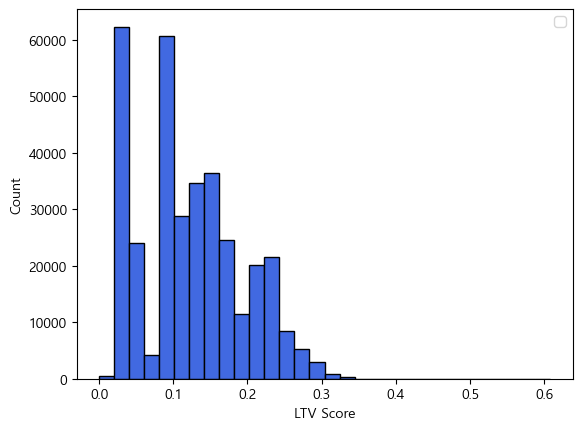

In [25]:
# 0.34 이상 상위 고객군만 필터링
high_value = df[df['LTV_Score'] >= 0]

# 분포 통계 확인
print(high_value['LTV_Score'].describe())

# 히스토그램으로 시각화 (선택)
import matplotlib.pyplot as plt

plt.hist(high_value['LTV_Score'], bins=30, color='royalblue', edgecolor='black')
plt.xlabel('LTV Score')
plt.ylabel('Count')
plt.legend()
plt.show()


In [13]:
df['LTV_Score'].describe()

count    347299.000000
mean          0.124016
std           0.069265
min           0.000000
25%           0.060577
50%           0.113567
75%           0.168191
max           0.607776
Name: LTV_Score, dtype: float64

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1) 대출·예금 규모
df['대출예금규모'] = df['총여신잔액'] + df['총예금잔액']

# 2) 카드 활용도 (신용+체크)
df['총카드사용액'] = df['신용카드사용금액'] + df['체크카드사용금액']

# 3) 로그 변환 적용 (거래 규모 관련 변수만)
df['대출예금규모_log'] = np.log1p(df['대출예금규모'])
df['총거래금액_log'] = np.log1p(df['총거래금액'])
df['총거래건수_log'] = np.log1p(df['총거래건수'])
df['총카드사용액_log'] = np.log1p(df['총카드사용액'])

# 4) 정규화 대상 컬럼 (로그 변환 후 스케일링)
cols_to_scale = ['대출예금규모_log', '총거래금액_log', '총거래건수_log', '총카드사용액_log']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# 5) LTV 점수 계산 (가중치 반영)
df['LTV_Score'] = (
    0.35 * df['대출예금규모_log'] +
    0.20 * df['총거래금액_log'] +
    0.20 * df['상품다양성지수'] +
    0.10 * df['총거래건수_log'] +
    0.05 * df['총카드사용액_log'] +
    0.10 * df['법인_고객등급']
)

print(df[['LTV_Score']].head())

   LTV_Score
0   0.136860
1   0.051287
2   0.251712
3   0.281817
4   0.255756


In [27]:
df['LTV_Score'].describe()

count    347299.000000
mean          0.265444
std           0.103892
min           0.000000
25%           0.186006
50%           0.260525
75%           0.339923
max           0.747583
Name: LTV_Score, dtype: float64

count    347299.000000
mean          0.265444
std           0.103892
min           0.000000
25%           0.186006
50%           0.260525
75%           0.339923
max           0.747583
Name: LTV_Score, dtype: float64


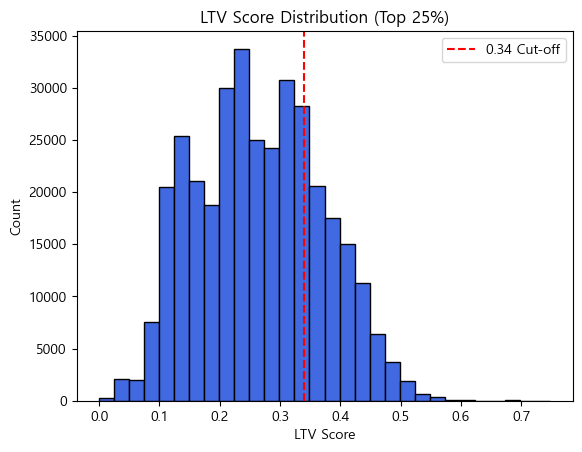

In [29]:
# 0.34 이상 상위 고객군만 필터링
high_value = df[df['LTV_Score'] >= 0]

# 분포 통계 확인
print(high_value['LTV_Score'].describe())

# 히스토그램으로 시각화 (선택)
import matplotlib.pyplot as plt

plt.hist(high_value['LTV_Score'], bins=30, color='royalblue', edgecolor='black')
plt.title('LTV Score Distribution (Top 25%)')
plt.xlabel('LTV Score')
plt.ylabel('Count')
plt.axvline(0.34, color='red', linestyle='--', label='0.34 Cut-off')
plt.legend()
plt.show()


In [31]:
# 1. VIP 필터링
vip_df = df[df['LTV_Score'] >= 0.34].copy()

In [33]:
vip_df['기준년월'].value_counts()

기준년월
202212    2587
202208    2547
202209    2546
202206    2541
202205    2538
202306    2523
202302    2522
202210    2522
202303    2514
202203    2512
202207    2508
202201    2503
202305    2497
202304    2486
202307    2483
202204    2476
202202    2472
202301    2406
202401    2373
202211    2350
202402    2336
202404    2335
202312    2326
202403    2325
202310    2323
202412    2323
202407    2314
202308    2311
202405    2299
202309    2297
202311    2295
202409    2286
202406    2268
202410    2267
202408    2240
202411    2222
Name: count, dtype: int64

In [36]:
group_cols = ['업종_중분류', '사업장_시도', '사업장_시군구']

# 2. 그룹화 및 중복 제거
vip_grouped = vip_df[group_cols].drop_duplicates().reset_index(drop=True)

# 3. 세그먼트 ID 생성
vip_grouped['세그먼트ID'] = (
    vip_grouped['업종_중분류'].astype(str) + '_' +
    vip_grouped['사업장_시도'].astype(str) + '_' +
    vip_grouped['사업장_시군구'].astype(str)
)

# 4. 결과 확인
print(vip_grouped.head())

           업종_중분류 사업장_시도 사업장_시군구                   세그먼트ID
0          종합 건설업  대전광역시      서구          종합 건설업_대전광역시_서구
1          종합 건설업  인천광역시      서구          종합 건설업_인천광역시_서구
2          종합 건설업  대구광역시      서구          종합 건설업_대구광역시_서구
3  기타 기계 및 장비 제조업  인천광역시      서구  기타 기계 및 장비 제조업_인천광역시_서구
4  기타 기계 및 장비 제조업  대구광역시      서구  기타 기계 및 장비 제조업_대구광역시_서구


In [37]:
vip_grouped

,업종_중분류,사업장_시도,사업장_시군구,세그먼트ID
0,종합 건설업,대전광역시,서구,종합 건설업_대전광역시_서구
1,종합 건설업,인천광역시,서구,종합 건설업_인천광역시_서구
2,종합 건설업,대구광역시,서구,종합 건설업_대구광역시_서구
3,기타 기계 및 장비 제조업,인천광역시,서구,기타 기계 및 장비 제조업_인천광역시_서구
4,기타 기계 및 장비 제조업,대구광역시,서구,기타 기계 및 장비 제조업_대구광역시_서구
...,...,...,...,...
1155,식료품 제조업,대구광역시,군위군,식료품 제조업_대구광역시_군위군
1156,화학물질 및 화학제품 제조업; 의약품 제외,울산광역시,남구,화학물질 및 화학제품 제조업; 의약품 제외_울산광역시_남구
1157,숙박업,부산광역시,사상구,숙박업_부산광역시_사상구
1158,기타 제품 제조업,경상남도,양산시,기타 제품 제조업_경상남도_양산시
